## Simple stock price prediction - NVDIA (Random Forest)

In [1]:
#Importing necessary libraries
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [2]:
# Download NVIDIA stock data from Yahoo Finance
nvda = yf.Ticker("NVDA").history(period="max")

# Add a column for the "next day's close price" and set the prediction target
nvda["Tomorrow"] = nvda["Close"].shift(-1)
nvda["Target"] = (nvda["Tomorrow"] > nvda["Close"]).astype(int)

# Filter data from the year 2000 onwards
nvda = nvda.loc["2000-01-01":].copy()

# Define a list of features (predictors) for the model
predictors = ["Close", "Volume", "Open", "High", "Low"]

In [3]:
# Create and train a Random Forest classifier on the data excluding the last 100 rows (for testing)
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
train = nvda.iloc[:-100]
test = nvda.iloc[-100:]

In [4]:
# Train the model and generate predictions
model.fit(train[predictors], train["Target"])
predictions = pd.Series(model.predict(test[predictors]), index=test.index)


In [5]:
# Evaluate the model using precision score
print(f"Precision Score: {precision_score(test['Target'], predictions)}")

Precision Score: 0.7


<Axes: xlabel='Date'>

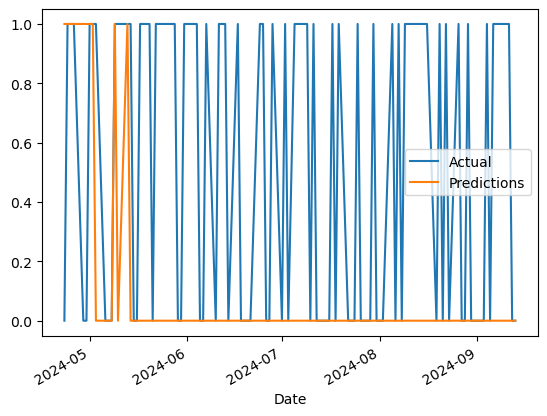

In [6]:
# Plot the actual vs predicted values
combined = pd.concat([test["Target"], predictions], axis=1)
combined.columns = ["Actual", "Predictions"]
combined.plot()

In [7]:
# Function to train and predict using the model for backtesting
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    predictions = pd.Series(model.predict(test[predictors]), index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], predictions], axis=1)
    return combined

In [8]:
# Function to backtest the model by iteratively training and predicting on chunks of data
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:i+step].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)


In [9]:
# Run backtest on the stock data
predictions = backtest(nvda, model, predictors)

In [11]:
# Display prediction statistics
print(predictions["Predictions"].value_counts())
print(f"Overall Precision: {precision_score(predictions['Target'], predictions['Predictions'])}")
print(predictions["Target"].value_counts() / predictions.shape[0])


Predictions
0    2061
1    1653
Name: count, dtype: int64
Overall Precision: 0.515426497277677
Target
1    0.528271
0    0.471729
Name: count, dtype: float64


In [12]:
# Adding new predictors: rolling averages and trend analysis
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    # Calculate rolling averages and trends for each horizon
    rolling_averages = nvda.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    nvda[ratio_column] = nvda["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    nvda[trend_column] = nvda["Target"].shift(1).rolling(horizon).sum()

    new_predictors += [ratio_column, trend_column]

# Remove any rows with missing values (due to rolling windows)
nvda = nvda.dropna()

In [13]:
# Update the model with new hyperparameters
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

# Update the prediction function to predict probabilities and threshold at 0.6
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    predictions = model.predict_proba(test[predictors])[:, 1]  # Predict probabilities
    predictions = pd.Series((predictions >= 0.6).astype(int), index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], predictions], axis=1)
    return combined

In [14]:
# Backtest using the new predictors
predictions = backtest(nvda, model, new_predictors)

# Display final results
print(predictions["Predictions"].value_counts())
print(f"Final Precision Score: {precision_score(predictions['Target'], predictions['Predictions'])}")

Predictions
0    1423
1     290
Name: count, dtype: int64
Final Precision Score: 0.5827586206896552
